# Notebook to generate DLC revenue metrics on monthly basis
## Pre-requisite
* You have collected the training and inference metrics excel file from DLC team and uploaded them to the bucket `autogluon-team-utils` hosted in team autogluon-dev account
* The excel data uses the following format:
```
	request_day	algorithm_name	internal	total_revenue	total_accounts	total_jobs
0	2023-10-08	autogluon-inference	external	9727.330437	226	443
1	2023-10-07	autogluon-inference	external	9843.909913	229	461
2	2023-10-06	autogluon-inference	external	9899.477409	244	500
3	2023-10-05	autogluon-inference	external	9831.855253	237	492
4	2023-10-04	autogluon-inference	external	9855.028542	231	475
```

## How to use
1. Modify `host_key` and `train_key` with latest excel file
2. Run the cell and use the second cell output as metrics reference


In [16]:
bucket = 'autogluon-team-utils'
host_key = 'metrics/dlc/2023/AutoGluon-Host-20230101-20231008.xlsx'
train_key = 'metrics/dlc/2023/AutoGluon-Train-20230101-20231008.xlsx'

import boto3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from io import BytesIO

def load_data_from_s3(bucket, key):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=key)
    data = obj['Body'].read()
    df = pd.read_excel(BytesIO(data))
    df['request_day'] = pd.to_datetime(df['request_day'])
    return df

def calculate_revenue(df):
    df_agg = df.groupby(['request_day', 'internal']).sum().reset_index()
    df_rev = df_agg.groupby(['internal'])['total_revenue'].sum().reset_index()
    total_rev = df_rev['total_revenue'].sum()
    internal_rev = df_rev[df_rev['internal'] == 'internal']['total_revenue'].sum()
    external_rev = df_rev[df_rev['internal'] == 'external']['total_revenue'].sum()
    return df_agg, total_rev, internal_rev, external_rev

def plot_data(df, y_label, y_value):
    plt.figure(figsize=(20,10))
    plt.title(f'{y_label} per day')
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.plot(df.groupby('request_day')[y_value].sum(), label=f'total {y_value}')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
    plt.legend()
    plt.show()

def plot_cumulative_revenue(df, df_external, df_internal):
    plt.figure(figsize=(20,10))
    plt.title('Cumulative Revenue')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Revenue')
    plt.plot(df.groupby('request_day')['total_revenue'].sum().cumsum(), label='total revenue')
    plt.plot(df_external.groupby('request_day')['total_revenue'].sum().cumsum(), label='total external revenue')
    plt.plot(df_internal.groupby('request_day')['total_revenue'].sum().cumsum(), label='total internal revenue')
    plt.legend()
    plt.show()
    
def plot_revenue(df_agg, df_external_agg, df_internal_agg):
    plt.figure(figsize=(20,10))
    plt.title('Container Daily Revenue')
    plt.xlabel('Date')
    plt.ylabel('Daily Revenue')
    plt.plot(df_agg.groupby('request_day')['total_revenue'].sum(), label='total revenue')
    plt.plot(df_external_agg.groupby('request_day')['total_revenue'].sum(), label='total external revenue')
    plt.plot(df_internal_agg.groupby('request_day')['total_revenue'].sum(), label='total internal revenue')
    plt.legend()
    plt.show()

Gross Revenue over last 4 weeks: $1,135,441.55
ARR: $13,625,298.62
Date Range: 2023-01-01 00:00:00 - 2023-10-08 00:00:00
Total containers revenue: $9,119,219.85
    train: $134,659.20 (1.48%)
    infer: $8,984,560.65 (98.52%)

    Internal customers revenue: $6,943,174.66 (76.14%)
        train: $67,716.29 (0.98%)
        infer: $6,875,458.37 (99.02%)
    External customers revenue: $2,176,045.19 (23.86%)
        train: $66,942.91 (3.08%)
        infer: $2,109,102.28 (96.92%)


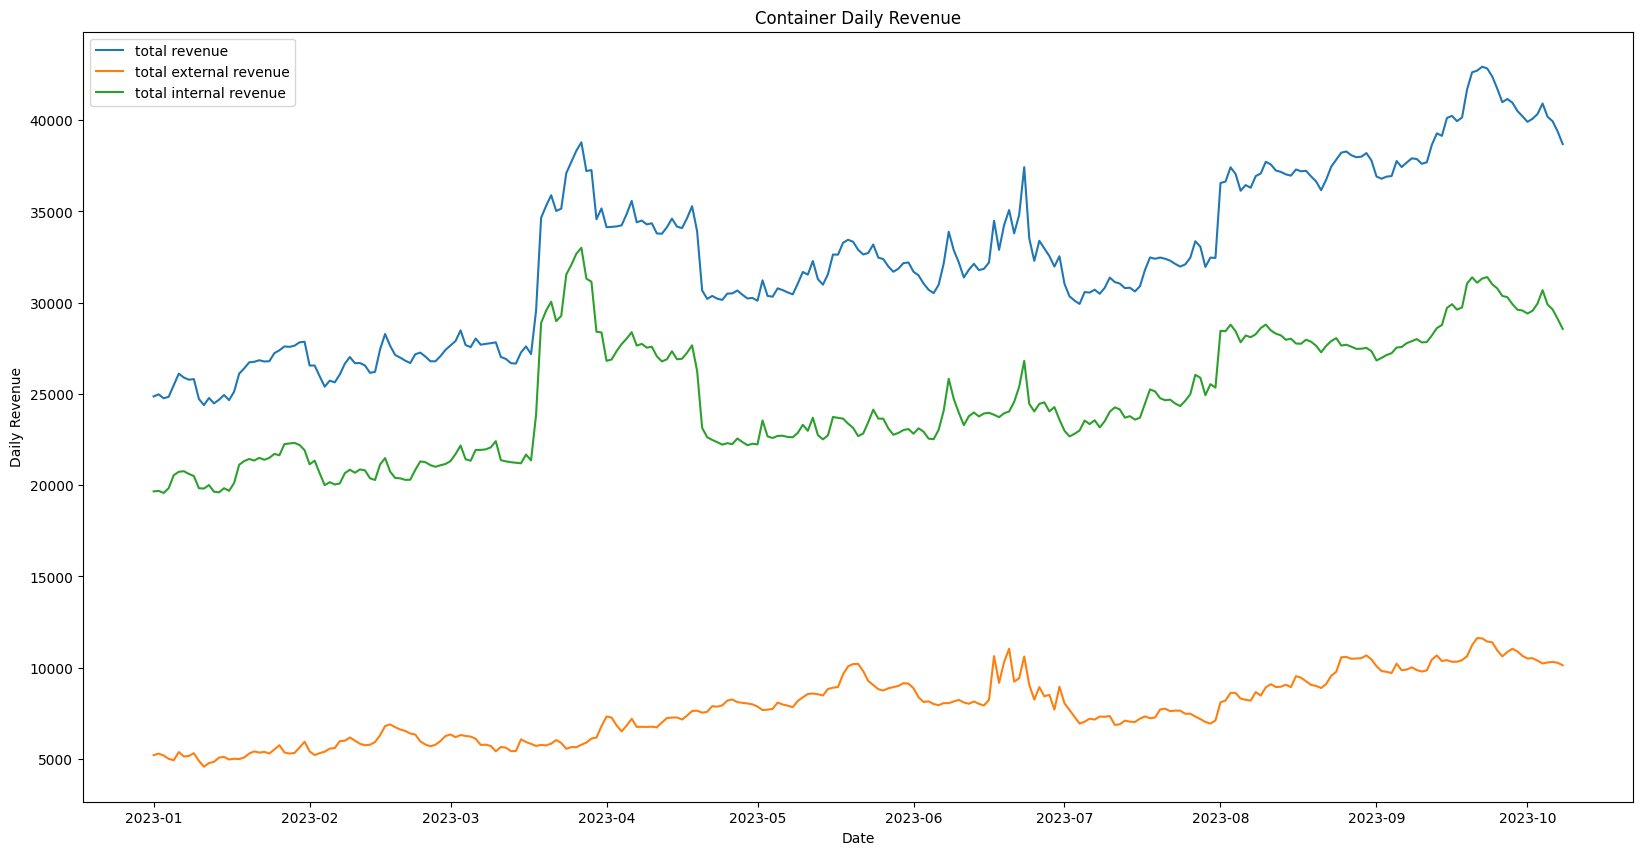

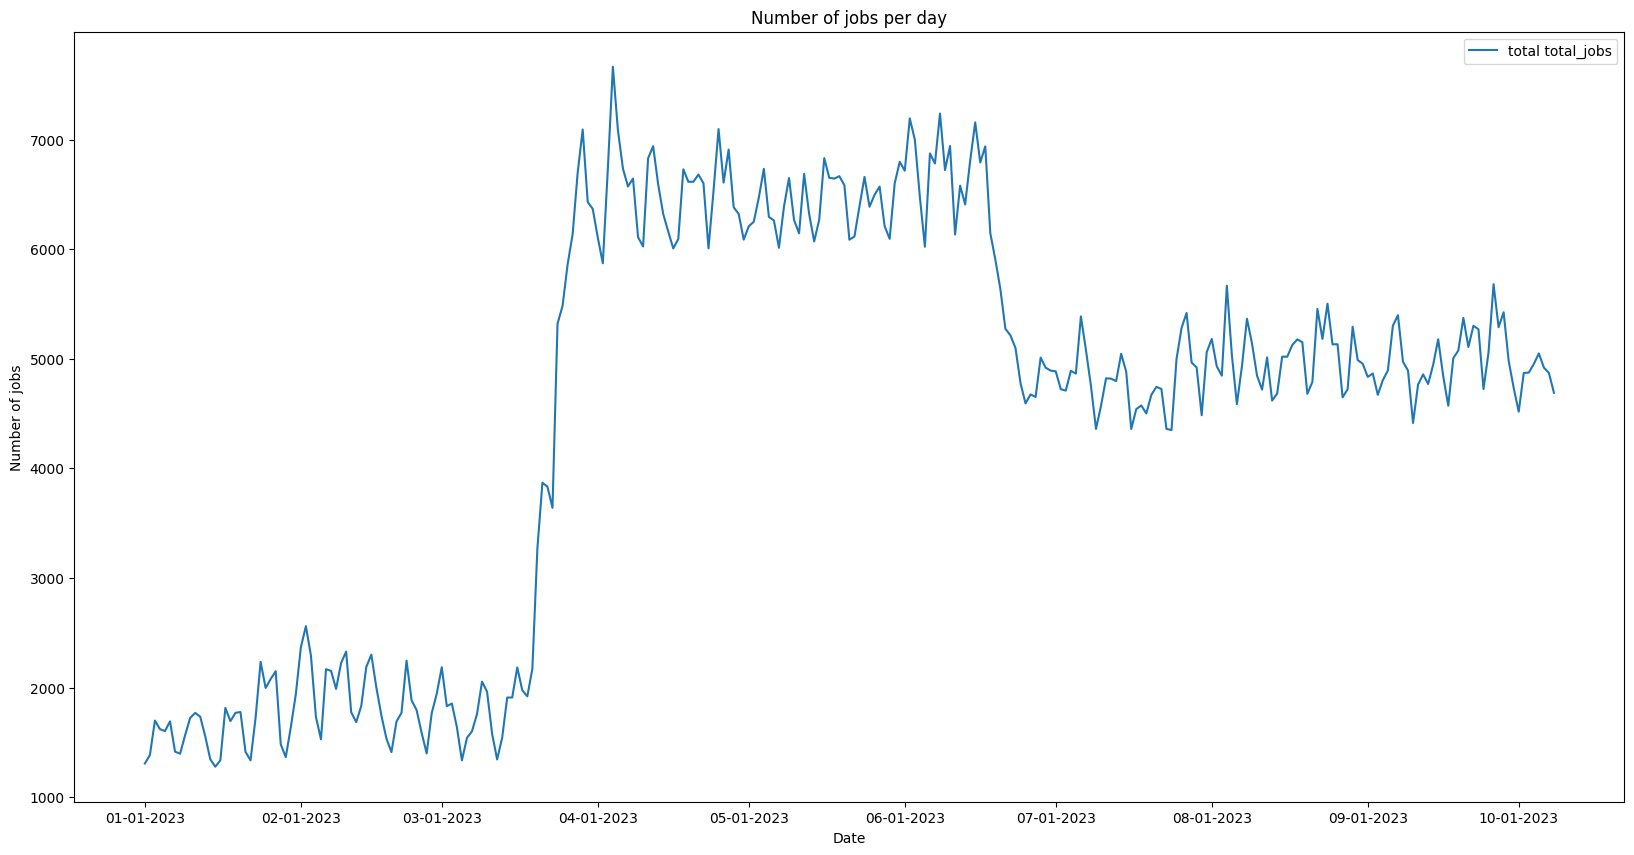

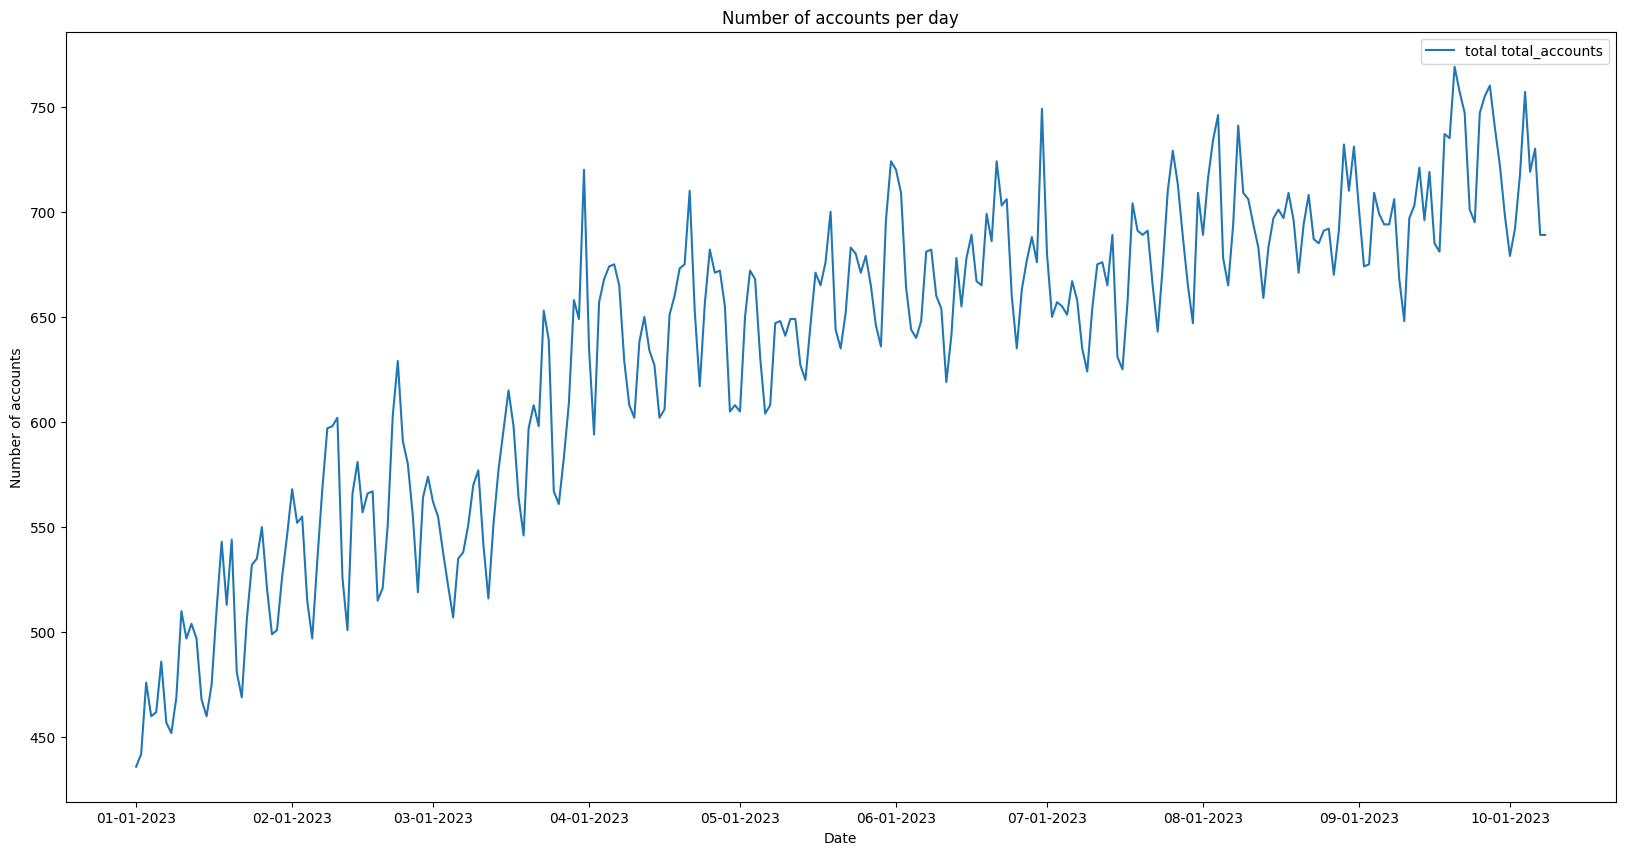

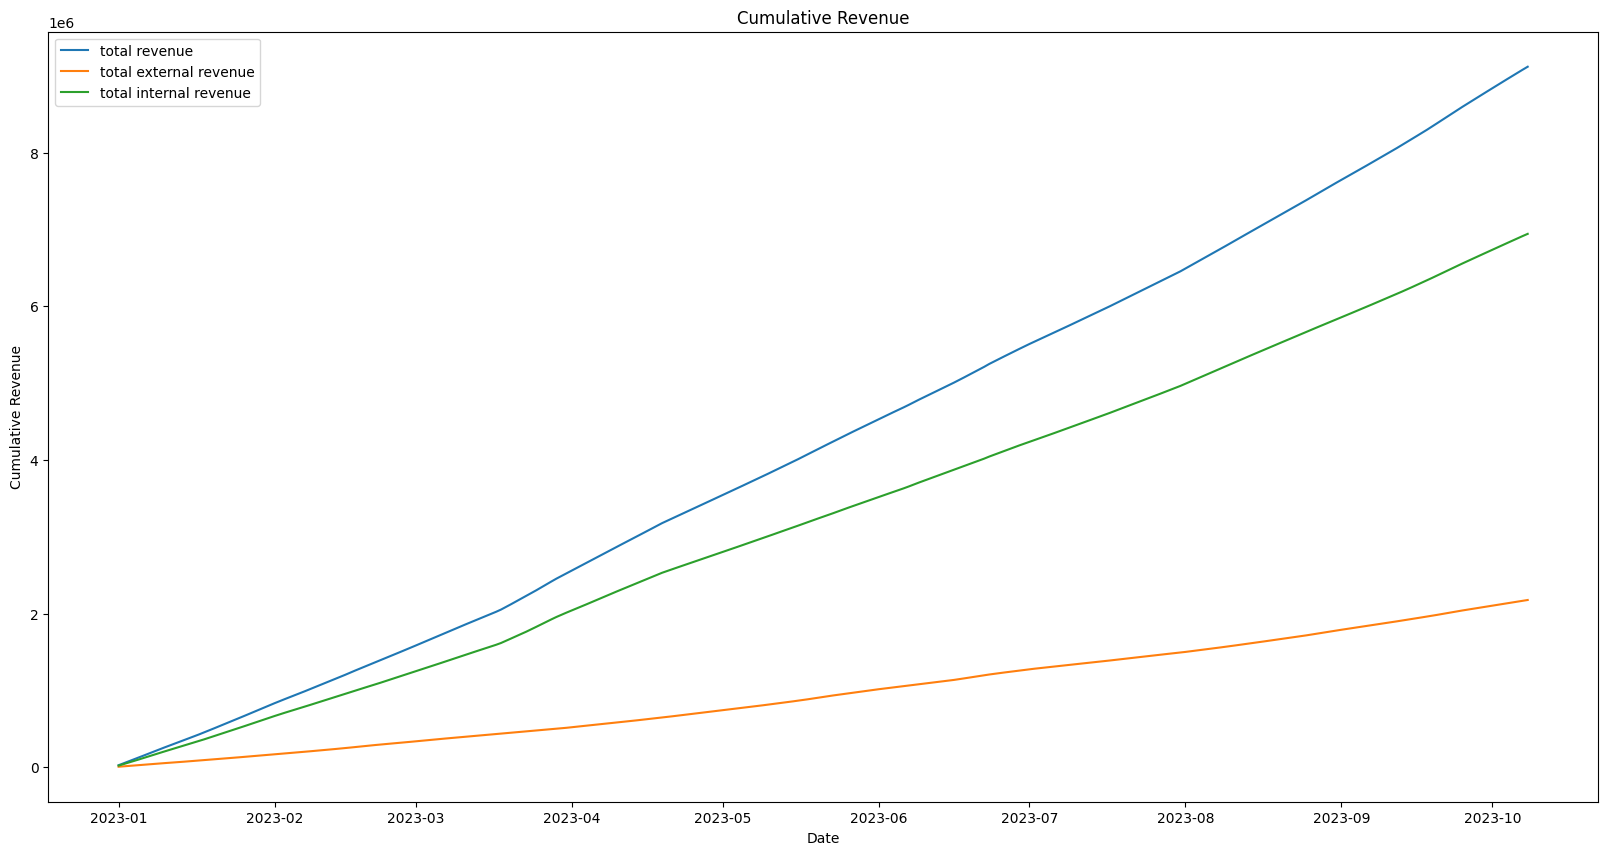

In [17]:
import warnings
import openpyxl

warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
df_host = load_data_from_s3(bucket, host_key)
df_train = load_data_from_s3(bucket, train_key)

df_train_agg, train_rev, internal_train_rev, external_train_rev = calculate_revenue(df_train)
df_host_agg, host_rev, internal_host_rev, external_host_rev = calculate_revenue(df_host)

df_agg = pd.concat([df_train_agg, df_host_agg], axis=0)
df_external_agg = df_agg[df_agg['internal'] == 'external']
df_internal_agg = df_agg[df_agg['internal'] == 'internal']



# print revenues
print(f"Gross Revenue over last 4 weeks: ${df_agg.groupby('request_day')['total_revenue'].sum().tail(28).sum():,.2f}")
print(f"ARR: ${12 * df_agg.groupby('request_day')['total_revenue'].sum().tail(28).sum():,.2f}")

# print the start and end date from df_train_agg using request_day column like 2023/01/01 - 2023/08/16
date_range = f"{df_train_agg['request_day'].min()} - {df_train_agg['request_day'].max()}"
print(f"Date Range: {date_range}")
print(f"Total containers revenue: ${(train_rev + host_rev):,.2f}")
print(f"    train: ${train_rev:,.2f} ({train_rev/(host_rev+train_rev)*100:.2f}%)")
print(f"    infer: ${host_rev:,.2f} ({host_rev/(host_rev+train_rev)*100:.2f}%)\n")

print(f"    Internal customers revenue: ${(internal_train_rev + internal_host_rev):,.2f} ({(internal_train_rev + internal_host_rev)/(train_rev+host_rev)*100:.2f}%)")
print(f"        train: ${internal_train_rev:,.2f} ({internal_train_rev/(internal_host_rev+internal_train_rev)*100:,.2f}%)")
print(f"        infer: ${internal_host_rev:,.2f} ({internal_host_rev/(internal_host_rev+internal_train_rev)*100:,.2f}%)")

print(f"    External customers revenue: ${(external_train_rev + external_host_rev):,.2f} ({(external_train_rev + external_host_rev)/(train_rev+host_rev)*100:.2f}%)")
print(f"        train: ${external_train_rev:,.2f} ({external_train_rev/(external_host_rev+external_train_rev)*100:,.2f}%)")
print(f"        infer: ${external_host_rev:,.2f} ({external_host_rev/(external_host_rev+external_train_rev)*100:,.2f}%)")

# Plot data
plot_revenue(df_agg, df_external_agg, df_internal_agg)
plot_data(df_agg, 'Number of jobs', 'total_jobs')
plot_data(df_agg, 'Number of accounts', 'total_accounts')
plot_cumulative_revenue(df_agg, df_external_agg, df_internal_agg)


In [18]:
df_host

,request_day,algorithm_name,internal,total_revenue,total_accounts,total_jobs
0,2023-10-08,autogluon-inference,external,9727.330437,226,443
1,2023-10-07,autogluon-inference,external,9843.909913,229,461
2,2023-10-06,autogluon-inference,external,9899.477409,244,500
3,2023-10-05,autogluon-inference,external,9831.855253,237,492
4,2023-10-04,autogluon-inference,external,9855.028542,231,475
...,...,...,...,...,...,...
4411,2023-01-05,signal-meter-autogluon,internal,484.255163,1,1
4412,2023-01-04,signal-meter-autogluon,internal,535.652661,1,1
4413,2023-01-03,signal-meter-autogluon,internal,459.846147,1,1
4414,2023-01-02,signal-meter-autogluon,internal,473.855123,1,1
